# Single file QC & multi file TIC check

Using pyOpenMS. Input file in mzML.

This notebook can be saved as a report in HTML or PDF.

This includes:
plots of TIC, chromatograms and mass distribution of internal standards (spike-in standards and 'house keeping' metabolites).

**plot multifile TIC**

To start this notebook:

Go to the docker folder of `pyopenms-qc` and run `docker compose up`

Minghao Gong, 2022-07-26

In [27]:
# install pyopenms if needed
import os
import numpy as np
import matplotlib.pyplot as plt

from pyopenms import *

In [28]:
# internal controls

# will change to using a tsv file of spike-in standards; and add negative mode

spikeins = [
    # name, M+H, RT,
    ('13C6-D-glucos', 187.0908, 0),
    ('trimethyl-13C3-caffeine', 198.0977, 0),
    ('15N-13C5-methionine', 156.0721, 0),
    ('13C5-L-glutamate', 153.0722, 0),
    ('15N2-uracil', 115.0286, 0),
    ('15N-L-tyrosine', 183.0782, 0),
]


# other regularly detected endogeneous metabolites to be used for control
other_controls = [
    # name, M+H, RT,
    ('phenylalanine', 166.0864, 48),
]

In [29]:
#
# key functions
#

def calcTIC(exp, mslevel=1):
    rt, tic = [], []
    # Iterate through all spectra of the experiment
    for spec in exp:
        # Only calculate TIC for matching (MS1) spectra
        if spec.getMSLevel() == mslevel:
            rt.append(spec.getRT())
            tic.append(sum(spec.get_peaks()[1]))

    return rt, tic

def extract_trio(exp, mslevel=1, min_intensity=1000):
    # return a list of [ (intensities, mz, rt), ...]
    trio_list = []
    for spec in exp:
        if spec.getMSLevel() == mslevel:
            this_rt = spec.getRT()
            # in OpenMS, spec.get_peaks() returns two lists: m/z and intensity in the scan.
            for m, i in zip(*spec.get_peaks()):
                if i > min_intensity:
                    # int(i) to save memory
                    trio_list.append( (int(i), m, this_rt) )
                    
    return trio_list

def get_targeted_mzrange(trio_list, mz_low, mz_high):
    # return trio_list sorted by intensity
    new = []
    for t in trio_list:
        # must in order of i, m, rt
        if mz_low < t[1] < mz_high:
            new.append(t)

    new.sort(reverse=True)
    return new

# warning: low intensity could indicate wrong peak identified
def plot_target_mzchrompeaks(full_trio_list, 
                             target_name,
                             target_mz, mz_error=0.003, 
                             target_rt=None, rt_error=10, min_intensity=10000,
                             figsize=(10,5) ):
    # rt not used right now
    range_low, range_high = target_mz-mz_error, target_mz+mz_error
    # sorted by intensity, must in order of i, m, rt
    use_data_points = get_targeted_mzrange( full_trio_list, range_low, range_high )

    # ax1 for m/z plot using log2 intensity, ax2 for chromatogram in linear intensity
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=figsize)
    
    # log2min_intensity = np.log2(min_intensity)
    RT, MZ, INS = [x[2] for x in use_data_points], [x[1] for x in use_data_points], [x[0] for x in use_data_points]
    log2INS = [np.log2(x) for x in INS]
    
    
    
    ax1.plot(MZ, log2INS, '.')
    ax1.set_xlim(range_low, range_high)
    ax1.set_title('m/z peaks')
    ax1.set_xlabel('m/z')
    ax1.set_ylabel('log2 intensity')
    #       
    ax2.plot(RT, INS, '.')
    ax2.set_title('chrom peaks')
    ax2.set_xlabel('time')
    ax2.set_ylabel('intensity')
    
    if INS and INS[0] > min_intensity:
        ppm = (MZ[0] - target_mz)/target_mz * 1e6
        fig.suptitle(target_name + '\n' +
                'top intensity at: %s, \nmass accuracy = %s ppm' %(str(MZ[0])[:9], str(ppm)[:5]))
    else:
        fig.suptitle(target_name + '\n' +
                "No signal detected above %d." %min_intensity)
                     
    plt.tight_layout()
    plt.show()
    
def plot_file(file, standard_list):
    exp = MSExperiment()
    MzMLFile().load(file, exp)
    
    # do TIC
    retention_times, intensities = calcTIC(exp)
    plt.plot(retention_times, intensities)
    plt.title(file + '\nTIC')
    plt.xlabel('time')
    plt.ylabel('intensity')
    plt.tight_layout()
    plt.show()
    
    # read trio data 
    full_trio_list = extract_trio(exp)

    # do internal standards
    for k in standard_list:
        plot_target_mzchrompeaks(full_trio_list, 
                             k[0],
                             k[1], mz_error=0.003, 
                             min_intensity=10000)
        
def plot_TIC_per_file(file):
    exp = MSExperiment()
    MzMLFile().load(file, exp)
    
    # do TIC
    retention_times, intensities = calcTIC(exp)
    plt.plot(retention_times, intensities)
    plt.title(file + '\nTIC')
    plt.xlabel('time')
    plt.ylabel('intensity')
    plt.tight_layout()
    plt.show()
    
    
def plot_TIC_multifile(file_dict):
    '''
    Example of file_dict
    ====================
    {sampleID: {file_path: "path2mzML",
                color: "green",
                group: "HEU"}
                ...
                }
    '''
    for k,v in file_dict.items():
        
        exp = MSExperiment()
        MzMLFile().load(v['file_path'], exp)
        # do TIC
        retention_times, intensities = calcTIC(exp)
        plt.plot(retention_times, intensities, color= v['color'], linewidth = 0.1,alpha = 0.8)
        
    plt.title('multiple files TIC')
    plt.xlabel('time')
    plt.ylabel('intensity')
    plt.tight_layout()
    plt.show()

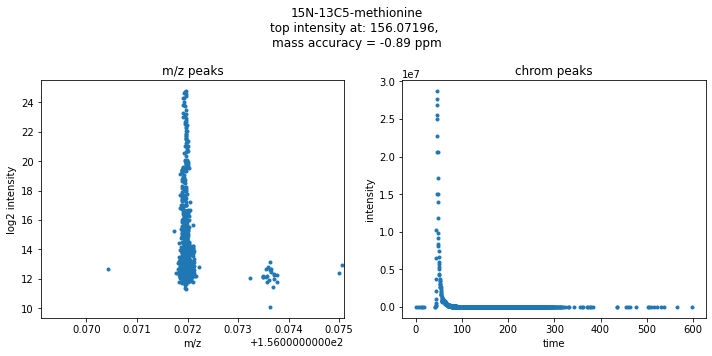

In [30]:
file = '../../input/HILICpos_mzML/G1_Naive_1_300_1.mzML'

# step wise

exp = MSExperiment()
MzMLFile().load(file, exp)

full_trio_list = extract_trio(exp)

plot_target_mzchrompeaks(full_trio_list, '15N-13C5-methionine', 156.0721)

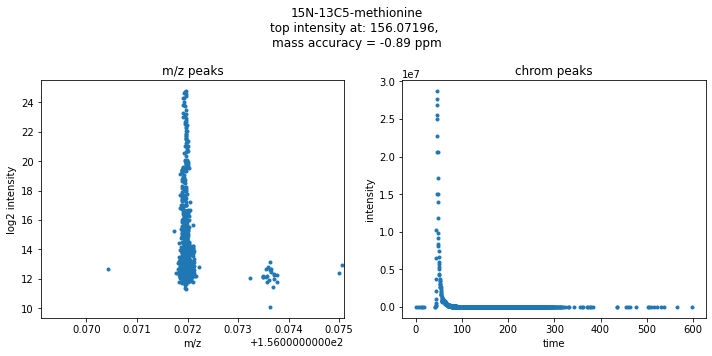

In [31]:
file = '../../input/HILICpos_mzML/G1_Naive_1_300_1.mzML'

# step wise

exp = MSExperiment()
MzMLFile().load(file, exp)

full_trio_list = extract_trio(exp)

plot_target_mzchrompeaks(full_trio_list, '15N-13C5-methionine', 156.0721)

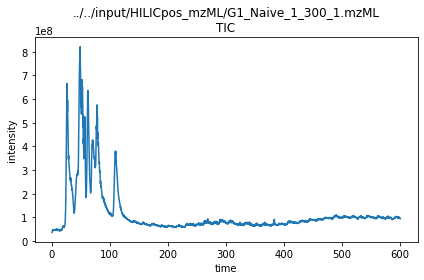

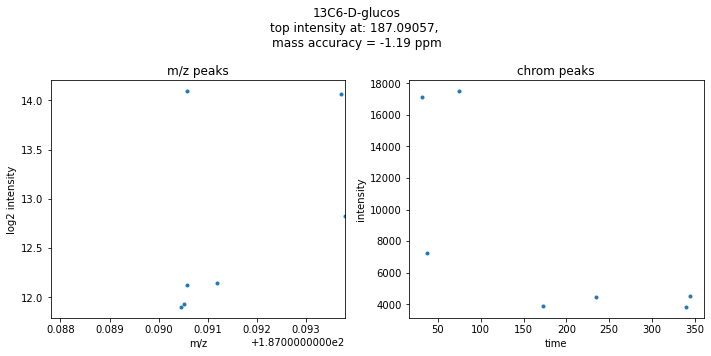

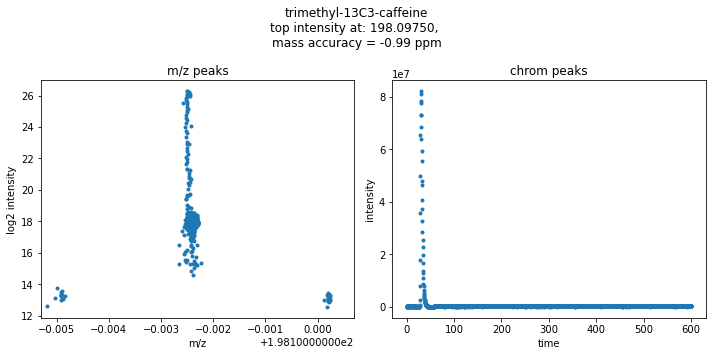

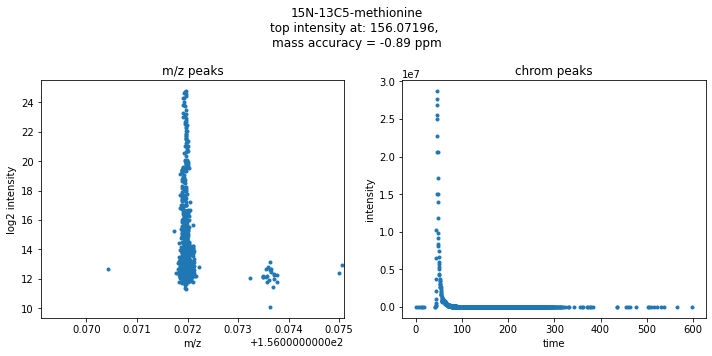

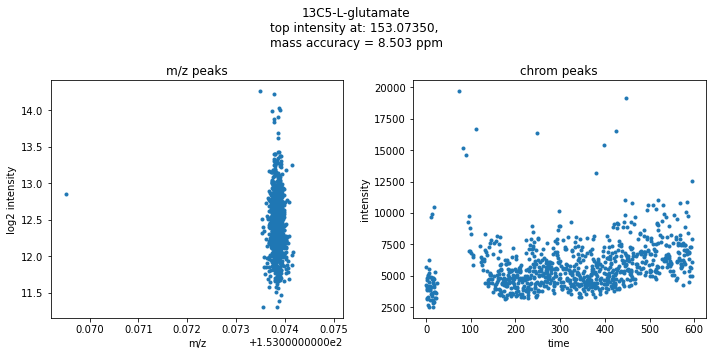

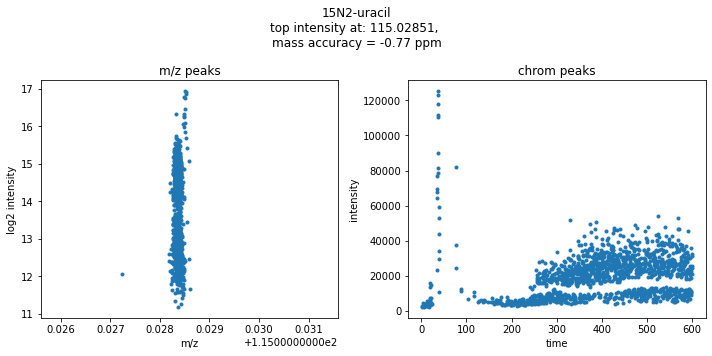

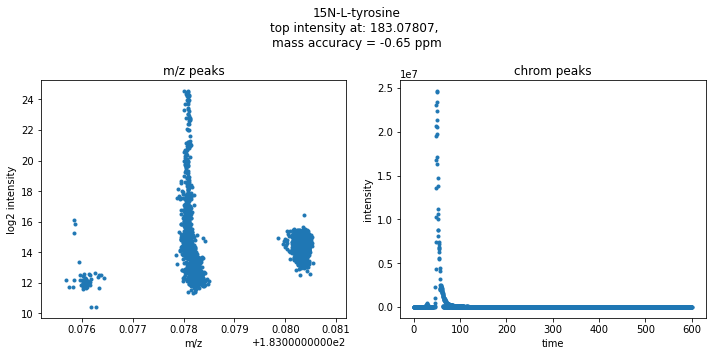

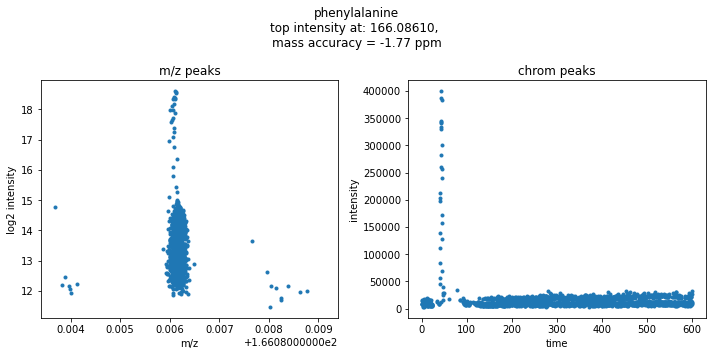

In [32]:
# full plot
file = '../../input/HILICpos_mzML/G1_Naive_1_300_1.mzML'
plot_file(file, spikeins + other_controls)
    

# Summary

This provides proto code for QC per data file.

The notebook can be saved to HTML to serve as a report.

To-do next:

1. to refactor to a standalone program, so that this is run wthout human intervention.

2. to continue onto QC using multiple QC samples and batch files.


------

------

------

# Plot multiple files of TIC

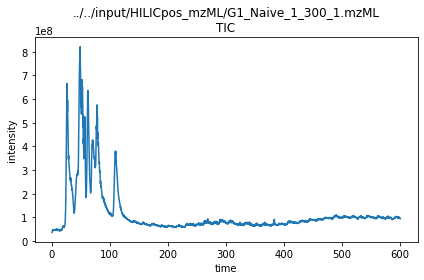

In [33]:
# just plot the TIC
plot_TIC_per_file('../../input/HILICpos_mzML/G1_Naive_1_300_1.mzML')

------

In [34]:
import os
import re
import pandas as pd

In [35]:
meta_df = pd.read_csv("../../input/sequence_file/clean_meta_df_wt1_HILICpos.csv")

In [36]:
meta_df

,index,tID,Sample ID,tID_dedup,class,biological_samples,cell_number
0,1,nist_1,nist_1,nist,nist,No,NaN
1,3,nist_3,nist_3,nist,nist,No,NaN
2,5,nist_5,nist_5,nist,nist,No,NaN
3,13,q3June2014_1b,q3June2014_1b_1,q3June2014_1,q3June2014,No,NaN
4,15,q3June2014_1b,q3June2014_1b_3,q3June2014_1,q3June2014,No,NaN
5,17,q3June2014_1b,q3June2014_1b_5,q3June2014_1,q3June2014,No,NaN
6,19,R5pos_1,G2_R5pos_1_142_1,R5pos_1,R5pos,Yes,142.0
7,21,R5pos_2,G2_R5pos_2_200_1,R5pos_2,R5pos,Yes,200.0
8,23,R5pos_3,G2_R5pos_3_150_1,R5pos_3,R5pos,Yes,150.0
9,25,Naive_1,G1_Naive_1_300_1,Naive_1,Naive,Yes,300.0


In [37]:
color_dict = {'Naive':'#888888',
              'R5neg':'#ff0000',
              'R5pos':'#0000ff'}

In [38]:
input_raw_fdr = "../../input/HILICpos_mzML/"

In [39]:
meta_df_sub = meta_df.loc[meta_df['class'].isin(['Naive','R5neg','R5pos'])]

In [40]:
file_dict = {}
for i,row in meta_df_sub.iterrows():
    file_dict[row['tID']] = {
        'file_path':os.path.join(input_raw_fdr,row['Sample ID']+ '.mzML'),
        'color': color_dict[row['class']],
        'group': row['class'],
    }

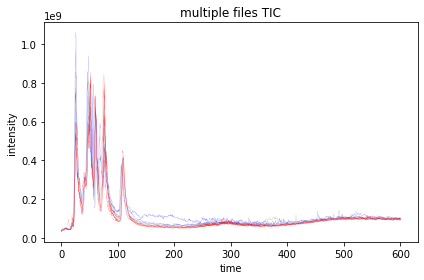

In [41]:
plot_TIC_multifile(file_dict)

### RT examination
- This does reflect systematic Retention time shift between samples. It will be better to perform analyses between batches with group randomized evenly across batches

------